# VAE+PE 

## Train VAE

In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np

from starccato_jax.data import load_data
import matplotlib.pyplot as plt
import os

HERE = os.getcwd()
model_savedir = f"{HERE}/model_out"

train_data, val_data = load_data()

plt.figure(figsize=(3, 2.5))
for i in range(100):
    plt.plot(train_data[i], color='k', lw=0.3, alpha=0.2);
plt.savefig(f"{model_savedir}/training_data.png")


![](model_out/training_data.png)

In [ ]:
from starccato_jax.trainer import train_vae

LATENT_DIM = 20

train_vae(train_data, val_data, n_epochs=200, batch_size=32, latent_dim=LATENT_DIM, save_dir=model_savedir)

| Loss | Reconstruction|
|---|---|
|![loss]| ![reconstructions] | 

[loss]: model_out/loss.png
[reconstructions]: model_out/reconstructions.png

/Users/avaj0001/Documents/projects/venvs/starccato_jax/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


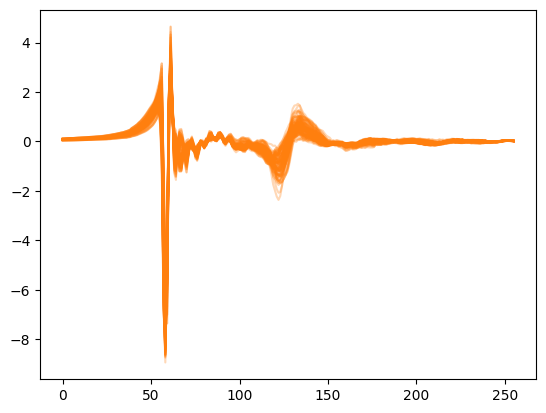

In [11]:
from starccato_jax.trainer import load_model
from starccato_jax.model import generate
import jax

zs = jax.random.uniform(jax.random.PRNGKey(0), (100, LATENT_DIM))

generated_signal = generate(*load_model(model_savedir), z=zs)
for i in range(100):
    plt.plot(generated_signal[i], color='tab:orange', alpha=0.3)

## MCMC on one validation dataset

/Users/avaj0001/Documents/projects/venvs/starccato_jax/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
/Users/avaj0001/Documents/projects/starccato_jax/src/starccato_jax/sampler.py:41: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000, num_chains=2, progres

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
z[0]   0.665  0.255   0.167    1.000      0.004    0.003    4032.0    2538.0   
z[1]   0.691  0.255   0.191    1.000      0.004    0.003    3499.0    2218.0   
z[2]   0.371  0.257   0.001    0.836      0.004    0.003    3778.0    2524.0   
z[3]   0.937  0.064   0.821    1.000      0.001    0.001    4269.0    1812.0   
z[4]   0.930  0.063   0.813    1.000      0.001    0.001    3241.0    1865.0   
z[5]   0.245  0.215   0.000    0.671      0.003    0.003    3919.0    1991.0   
z[6]   0.232  0.208   0.000    0.634      0.004    0.004    3176.0    1761.0   
z[7]   0.513  0.285   0.061    0.994      0.004    0.003    4266.0    1838.0   
z[8]   0.397  0.282   0.001    0.905      0.005    0.004    4029.0    2473.0   
z[9]   0.333  0.259   0.000    0.823      0.004    0.004    3750.0    2122.0   
z[10]  0.246  0.208   0.000    0.653      0.003    0.003    3696.0    2307.0   
z[11]  0.188  0.173   0.000    0.517    

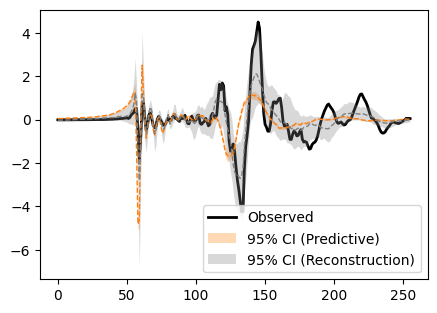

In [12]:
from starccato_jax.sampler import sample_latent_vars_given_data

mcmc_out = sample_latent_vars_given_data(val_data[10], model_savedir, rng_int=0, outdir=f"{HERE}/out_mcmc")

It’s always a good idea to check the convergence of your MCMC sampler, and we’ll use ArviZ to do that here, looking at the Gelman–Rubin (r_hat) statistic, and the effective sample sizes (e.g. ess_bulk):

In [114]:
import arviz as az

inf_data = az.from_numpyro(mcmc_out)
az.summary(inf_data, var_names=['z'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z[0],0.132,0.130,0.000,0.380,0.003,0.002,2076.0,2045.0,1.0
z[1],0.157,0.125,0.001,0.385,0.002,0.002,2669.0,2001.0,1.0
z[2],0.285,0.194,0.000,0.630,0.004,0.003,1891.0,1864.0,1.0
z[3],0.305,0.213,0.000,0.693,0.005,0.003,1987.0,1930.0,1.0
z[4],0.081,0.102,0.000,0.271,0.002,0.002,2088.0,2271.0,1.0
z[5],0.229,0.166,0.000,0.519,0.003,0.002,2247.0,2025.0,1.0
z[6],0.173,0.156,0.000,0.467,0.003,0.002,2330.0,1973.0,1.0
z[7],0.219,0.137,0.001,0.454,0.002,0.002,2785.0,1603.0,1.0
z[8],0.227,0.153,0.000,0.497,0.003,0.002,2085.0,2026.0,1.0
z[9],0.091,0.082,0.000,0.242,0.001,0.001,3014.0,2035.0,1.0


|        | |
|--------|--|
| Trace  | ![trace_plot][trace_plot] |
| Corner | ![corner_plot][corner_plot] |
| CI     | ![ci_plot][ci_plot] |


[ci_plot]: out_mcmc/ci_plot.png
[corner_plot]: out_mcmc/corner_plot.png
[trace_plot]: out_mcmc/trace_plot.png

## Exploring better number of Z


In [ ]:
from starccato_jax.trainer import train_vae

for z_size in [4, 8, 12, 16, 20]:
    train_vae(train_data, val_data, latent_dim=z_size, n_epochs=200,
              save_dir=f"{HERE}/model_exploration/model_z{z_size}"
              )

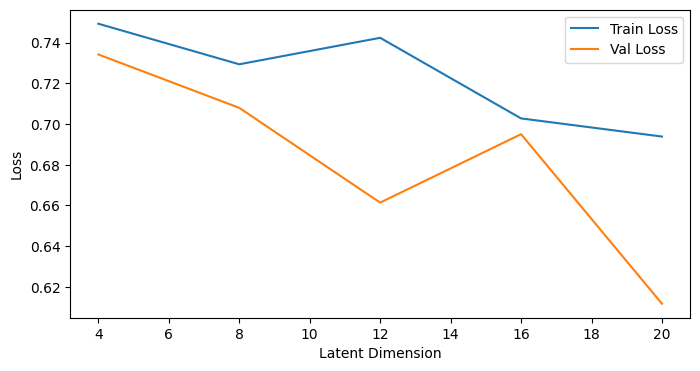

In [9]:
z_sizes = [4, 8, 12, 16, 20]


train_losses, val_losses  = [], []
for z_size in z_sizes:
    # read the losses
    loss_fpath = f"{HERE}/model_exploration/model_z{z_size}/losses.txt"
    data = np.loadtxt(loss_fpath)
    train_losses.append(data[-1, 0])
    val_losses.append(data[-1, 1])



## PLOT
plt.figure(figsize=(8, 4))
plt.plot(z_sizes, train_losses, label="Train Loss")
plt.plot(z_sizes, val_losses, label="Val Loss")
plt.xlabel('Latent Dimension')
plt.ylabel('Loss')
plt.title("Loss at 200 epochs")
plt.legend()
